In [27]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import minimize,basinhopping
import io
from PIL import Image


In [28]:
# 指定文件夹路径
folder_path = 'testphotos'
# 获取文件夹下的所有文件和子文件夹
files_and_folders = os.listdir(folder_path)
# 过滤出文件
photoname = [file for file in files_and_folders if os.path.isfile(os.path.join(folder_path, file))]
photopath = [os.path.join(folder_path, file) for file in files_and_folders if os.path.isfile(os.path.join(folder_path, file))]
print(photopath)

['testphotos\\1.png', 'testphotos\\2.png', 'testphotos\\img copy 2.png', 'testphotos\\img copy.png', 'testphotos\\img.png']


In [29]:
'''d0默认值为10：
这是一个参数，用于定义高通滤波器的截止频率。d0 控制了滤波器对低频成分的衰减程度，即距离原点（0频率）多远的频率成分开始被衰减。

rl默认值为0.5：
这是滤波器在低频区域的增益。rl 控制了滤波器对低频成分的保留程度。

rh默认值为2.0：
这是滤波器在高频区域的增益。rh 控制了滤波器对高频成分的增强程度。

c默认值为4：锐化系数
这是一个参数，用于控制滤波器的陡峭程度。c 的值越大，滤波器的过渡带就越窄，即从低频到高频的过渡就越快。

h默认值为2.0：
这是输出图像的最大值。在同态滤波过程中，可能会产生超出常规图像值范围（0-255）的结果，h 用于将结果缩放到这个最大值。

l默认值为0.5：

这是输出图像的最小值。与 h 类似，l 用于确保输出图像的值不会低于这个最小值。'''
def homomorphic_filter(src, d0=10, rl=1, rh=2, c=4, h=2.0, l=0.5):
    gray = src.copy()
    gray = np.log(1e-5 + gray)  # 取对数
    rows, cols = gray.shape
    gray_fft = np.fft.fft2(gray)  # FFT傅里叶变换
    gray_fftshift = np.fft.fftshift(gray_fft)  # FFT中心化
    M, N = np.meshgrid(np.arange(-cols // 2, cols // 2), np.arange(-rows // 2, rows // 2))
    D = np.sqrt(M ** 2 + N ** 2)  # 计算距离
    Z = (rh - rl) * (1 - np.exp(-c * (D ** 2 / d0 ** 2))) + rl  # H(u,v)传输函数
    dst_fftshift = Z * gray_fftshift
    dst_fftshift = (h - l) * dst_fftshift + l
    dst_ifftshift = np.fft.ifftshift(dst_fftshift)
    dst_ifft = np.fft.ifft2(dst_ifftshift)  # IFFT逆傅里叶变换
    dst = np.real(dst_ifft)  # IFFT取实部
    dst = np.exp(dst) - 1  # 还原
    dst = np.uint8(np.clip(dst, 0, 255))
    return dst

In [30]:
# 定义分段函数
def piecewise(x,x0,x1,y0,y1,k0,k1):
    return np.piecewise(x , [x <= x0, np.logical_and(x0<x, x<x1),x>x1] ,
                        [lambda x:k0*(x-x0) + y0,#根据点斜式构建函数
                        lambda x:(x-x0)*(y1-y0)/(x1-x0)+y0,#根据两点式构建函数
                        lambda x:k1*(x-x1) + y1])
# 广义伽马校正公式拟合
def gamma_func(x, alpha, delta, gamma):
    return 255 * (x / 255) ** (alpha / (x + delta) + gamma)
# 迭代拟合
def iterative_fit(xdata, ydata, initial_guess, max_iter=10, tol=1e-6):
    popt, pcov = curve_fit(gamma_func, xdata, ydata, p0=initial_guess)
    for _ in range(max_iter - 1):
        new_popt, new_pcov = curve_fit(gamma_func, xdata, ydata, p0=popt,method='dogbox')
        if np.allclose(new_popt, popt, atol=tol):
            break
        popt = new_popt
    return popt, pcov

def save_figure_to_image():
    """保存当前plt图像到变量中"""
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    plt.clf()
    return Image.open(buf)


In [31]:
def calgraylevel(image_gray):
    # 计算直方图
    histogram = cv2.calcHist([image_gray], [0], None, [256], [0, 256])
    histogram = histogram.ravel()  # 将直方图展平为一维数组,频率
    # 找到峰值对应的灰度级
    imax = np.argmax(histogram)  # imax是直方图最大值的索引，即峰值灰度级
    imin = np.argmin(histogram)
    f_max = histogram[imax]  # f_max是imax对应的频率值，即峰值频率

    xdata = np.arange(imax)#灰度
    ydata = histogram[:imax]#频率
    #ydata = ydata.ravel() / image_gray.size
    plt.plot(ydata)
    image1 = save_figure_to_image()

    
    #根据分段函数进行拟合，通过迭代寻找最优的p，即为p_best
    #注：p（p_best）中包含的是拟合之后求得的所有未知参数
    perr_min = np.inf
    for n in range(100):
        k = np.random.rand(6)*20
        #k=np.array([10,20,10,10,10,0])
        p , e = curve_fit(piecewise, xdata, ydata,p0=k)
        perr = np.sum(np.abs(ydata-piecewise(xdata, *p)))
        if(perr < perr_min):
            perr_min = perr
            p_best = p
            print(f'k:{k}')

    print(f"p_best:{p_best}")
    #根据p_best调用curve_fit函数绘制拟合图像
    xd = np.linspace(0, imax, 100)
    if_=p_best[0]
    it_=p_best[1]
    print(f'if_{if_},it_{it_}')
    plt.figure()
    plt.plot(xd, piecewise(xd, *p_best))
    xx=(p_best[0],p_best[1])
    yy=(p_best[2],p_best[3])

    plt.scatter(xx,yy,s=30,c='black')

    image2 = save_figure_to_image()

    # 使用已知点拟合参数
    #popt, _ = curve_fit(gamma_func, np.array([0, imin, if_, it_, 255]), np.array([0, 0, if_, imax, 255]))
    #alpha, delta, gamma = popt

    # 初始参数猜测
    initial_guess = [120.0, 1.0, 1.0]

    # 执行迭代拟合
    popt, pcov = iterative_fit(np.array([0, imin, if_, it_, 255]), np.array([0, 0, if_, imax, 255]), initial_guess)
    alpha, delta, gamma = popt
    print("Optimized parameters:", popt)

    # 应用广义伽马校正
    corrected_image = np.clip(gamma_func(image_gray, alpha, delta, gamma), 0, 255).astype(np.uint8)

    # 显示原图和校正后的图像
    plt.figure(figsize=(12, 9))
    plt.subplot(1, 2, 1)
    plt.imshow(image_gray, cmap='gray')
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(corrected_image, cmap='gray')
    plt.title('Gamma Corrected Image')
    plt.tight_layout()  # 自动调整布局
    image3 = save_figure_to_image()

    #校正前图像，校正后图像image_gray,corrected_image

    # 假设你已经有了以下变量
    # image_gray: 灰度图像
    # imin, if_, it_, imax: 已知的灰度级点
    # alpha, delta, gamma: 拟合得到的参数

    # 广义伽马校正公式
    #if if_==0:
    #    if_=5
    # 已知点
    x_data = np.array([0, imin, if_, it_, 255])
    y_data = np.array([0, 0, if_, imax, 255])

    # 绘制原始数据点
    plt.figure(figsize=(10, 5))
    plt.scatter(x_data, y_data, color='red', label='Original Data Points')

    # 绘制拟合曲线
    x_fit = np.linspace(0, 255, 256)
    y_fit = gamma_func(x_fit, alpha, delta, gamma)
    plt.plot(x_fit, y_fit, label='Fitted Gamma Curve')

    x1, y1 = 0, 0
    x2, y2 = 255, 255

    # 使用plot函数绘制两点之间的连线
    plt.plot([x1, x2], [y1, y2],color='black')  # marker='o'表示在每个点上放置一个圆圈标记

    plt.title('Gamma Correction Fitting')
    plt.xlabel('Input Intensity Values')
    plt.ylabel('Output Intensity Values')
    image4 = save_figure_to_image()

    
    return corrected_image, image1, image2, image3, image4


testphotos\2.png
k:[ 2.04089759 15.39324553 17.88054265  5.89475641  1.89169471 19.8513482 ]
k:[18.0700171  16.18760248  0.54636131 13.25851649 12.77417691  3.45582106]


C:\Users\64473\AppData\Local\Temp\ipykernel_11836\2948174226.py:23: OptimizeWarning: Covariance of the parameters could not be estimated
  p , e = curve_fit(piecewise, xdata, ydata,p0=k)


p_best:[  92.80181991  116.5355404   668.86583829 4152.73858413    6.06021903
  475.13288986]
if_92.80181990545977,it_116.53554039612885
Optimized parameters: [6.08869823e+01 4.71427566e-09 2.08880864e-01]


C:\Users\64473\AppData\Local\Temp\ipykernel_11836\1468719636.py:9: RuntimeWarning: divide by zero encountered in power
  return 255 * (x / 255) ** (alpha / (x + delta) + gamma)


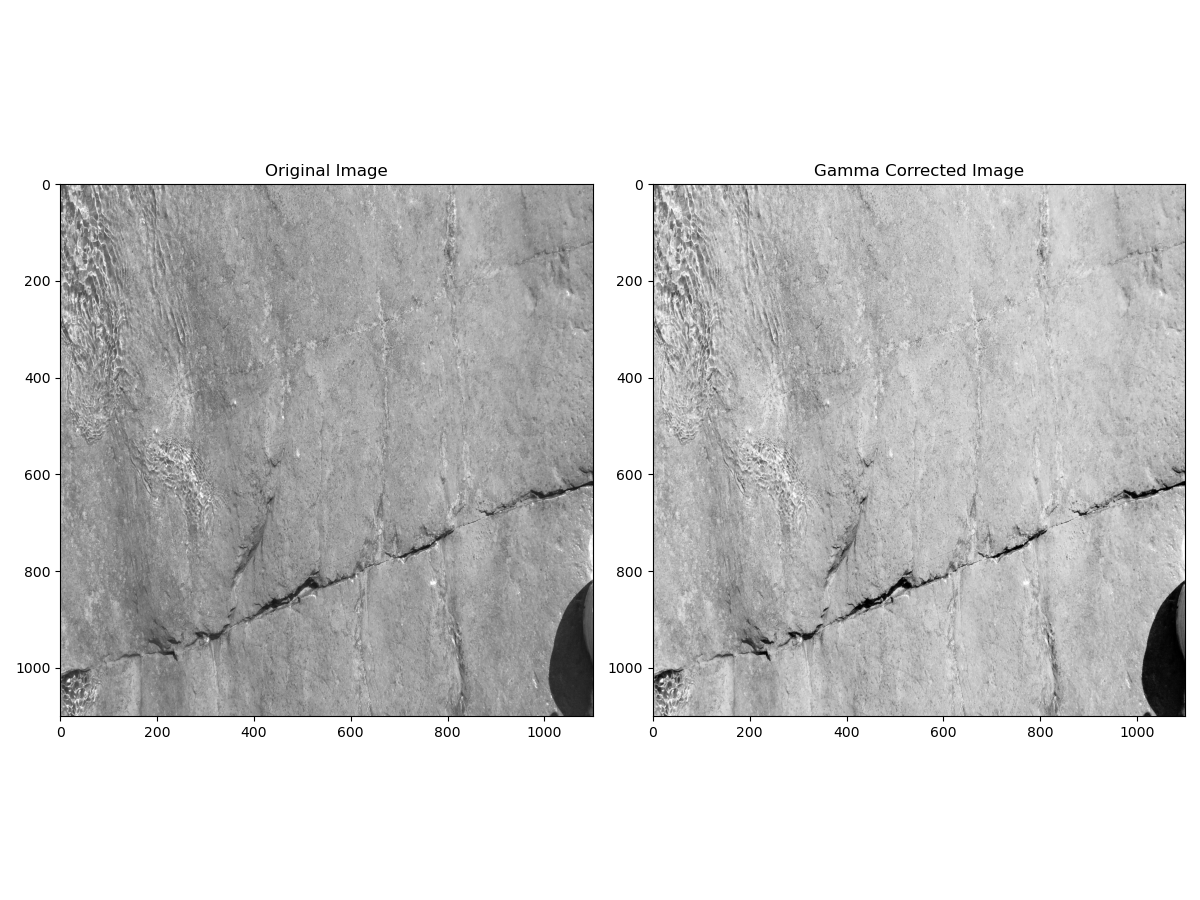

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1200x900 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [32]:
i=1
print(photopath[i])
# 读取图片
image_color = cv2.imread(photopath[i])
image_gray = cv2.cvtColor(image_color, cv2.COLOR_RGB2GRAY)

graylevelimg, image1, image2, image3, image4 = calgraylevel(image_gray)
display(image3.convert('RGB'))
#image1.show()

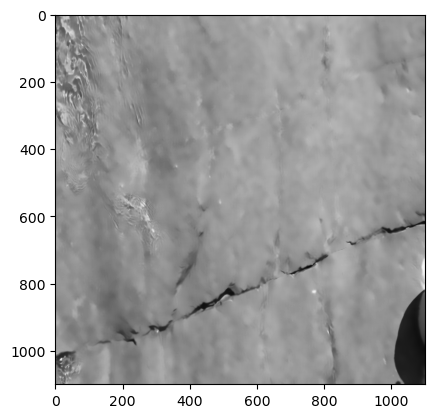

In [33]:
# h 是滤波系数，用于控制去噪强度，值越大去噪效果越强，但可能会导致图像模糊
# templateWindowSize 是用于计算权重的窗口大小，通常为3, 5, 7等奇数
# searchWindowSize 是搜索窗口的大小，通常比templateWindowSize大，也是奇数

dst = cv2.fastNlMeansDenoising(image_gray, h=30, templateWindowSize=7, searchWindowSize=21)
#plt.imshow(image_gray, cmap='gray')
plt.imshow(dst, cmap='gray')

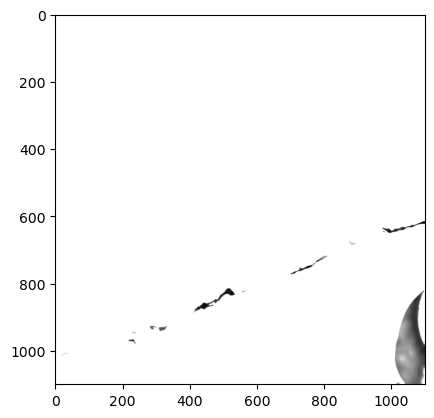

In [34]:
image_homomorphic_filter = homomorphic_filter(dst,d0=10, rl=1.1, rh=2.5, c=4, h=2, l=0.5)
# 显示结果
plt.imshow(image_homomorphic_filter, cmap='gray')

In [35]:
from scipy import ndimage

import SimpleITK as sitk 

class vesselness2d:
    def __init__(self, image, sigma, spacing, tau):
        super(vesselness2d, self).__init__()
        # image 为numpy类型，表示n * m 的二维矩阵。
        self.image = image
        # sigma 为list 类型，表示高斯核的尺度。
        self.sigma = sigma
        # spacing 为list类型，表示.nii文件下某一切面下的体素的二维尺寸。如果输入图像本身为二维图像，则为[1,1],如果为三维图像，则为对应的space。
        self.spacing = spacing
        # tau 为float类型，表示比例系数。
        self.tau = tau
        # 图像尺寸
        self.size = image.shape
	
	# 使用特定的特定sigma尺寸下的高斯核对图像滤波
	# 这里作者并没有使用n*n的卷积核，而是分别使用n*1，1*n的卷积对图像进行x和y方向上的卷积，
	# 并且使用的是最原始的计算高斯函数得到卷积核，而不是直接用现成的高斯卷积核，
	# 通过证明可以发现在两方面的结果是等价的。
    def gaussian1(self, image, sigma):
        
        return cv2.GaussianBlur(image,(0,0),sigma)

    def gaussian(self, image, sigma):
        siz = sigma * 6 # 核的尺寸
        
        # x轴方向上的滤波
        temp = round(siz / self.spacing[0] / 2)
        x = [i for i in range(-temp, temp + 1)]
        x = np.array(x)
        H = np.exp(-(x ** 2 / (2 * ((sigma / self.spacing[0]) ** 2))))
        H = H / np.sum(H)
        Hx = H.reshape(len(H), 1)
        I = ndimage.convolve(image, Hx, mode='nearest')
        
        # y轴方向上的滤波
        temp = round(siz / self.spacing[1] / 2)
        x = [i for i in range(-temp, temp + 1)]
        x = np.array(x)
        H = np.exp(-(x ** 2 / (2 * ((sigma / self.spacing[1]) ** 2))))
        H = H / np.sum(H[:])
        Hy = H.reshape(1, len(H))
        I = ndimage.convolve(I, Hy, mode='nearest')
        return I

	# 求图像的梯度
    def gradient2(self, F, option):
        k = self.size[0]
        l = self.size[1]
        D = np.zeros(F.shape)
        if option == "x":
            D[0, :] = F[1, :] - F[0, :]
            D[k - 1, :] = F[k - 1, :] - F[k - 2, :]
            # take center differences on interior points
            D[1:k - 2, :] = (F[2:k - 1, :] - F[0:k - 3, :]) / 2
        else:
            D[:, 0] = F[:, 1] - F[:, 0]
            D[:, l - 1] = F[:, l - 1] - F[:, l - 2]
            D[:, 1:l - 2] = (F[:, 2:l - 1] - F[:, 0:l - 3]) / 2
        return D
        
	# 求海森矩阵中所需要的二阶偏导数
    def Hessian2d(self, image, sigma):
        image = self.gaussian(image, sigma)
        # image = ndimage.gaussian_filter(image, sigma, mode = 'nearest')
        Dy = self.gradient2(image, "y")
        Dyy = self.gradient2(Dy, "y")

        Dx = self.gradient2(image, "x")
        Dxx = self.gradient2(Dx, "x")
        Dxy = self.gradient2(Dx, 'y')
        return Dxx, Dyy, Dxy
	
	# 求解海森矩阵的两个特征值
	# 这里作者使用求根公式，将二阶海森矩阵展开，a=1,b=-(Ixx+Iyy),c=(Ixx*Iyy-Ixy*Ixy) 
	# 首先计算 sqrt(b^2 - 4ac),通过化简得到tmp
	# 最后得到两个特征值mu1，mu2，根据大小关系，大的为mu2，小的为mu1
    def eigvalOfhessian2d(self, Dxx, Dyy, Dxy):
        tmp = np.sqrt((Dxx - Dyy) ** 2 + 4 * (Dxy ** 2))
        # compute eigenvectors of J, v1 and v2
        mu1 = 0.5 * (Dxx + Dyy + tmp)
        mu2 = 0.5 * (Dxx + Dyy - tmp)
        # Sort eigen values by absolute value abs(Lambda1) < abs(Lambda2)
        indices = (np.absolute(mu1) > np.absolute(mu2))
        Lambda1 = mu1
        Lambda1[indices] = mu2[indices]

        Lambda2 = mu2
        Lambda2[indices] = mu1[indices]
        return Lambda1, Lambda2

    def imageEigenvalues(self, I, sigma):
        hxx, hyy, hxy = self.Hessian2d(I, sigma)
        c = sigma ** 2
        hxx = -c * hxx
        hyy = -c * hyy
        hxy = -c * hxy

        # 为了降低运算量，去掉噪声项的计算
        B1 = -(hxx + hyy)
        B2 = hxx * hyy - hxy ** 2
        T = np.ones(B1.shape)
        T[(B1 < 0)] = 0
        T[(B1 == 0) & (B2 == 0)] = 0
        T = T.flatten()
        indeces = np.where(T == 1)[0]

        hxx = hxx.flatten()
        hyy = hyy.flatten()
        hxy = hxy.flatten()

        hxx = hxx[indeces]
        hyy = hyy[indeces]
        hxy = hxy[indeces]


        lambda1i, lambda2i = self.eigvalOfhessian2d(hxx, hyy, hxy)
        lambda1 = np.zeros(self.size[0] * self.size[1], )
        lambda2 = np.zeros(self.size[0] * self.size[1], )

        lambda1[indeces] = lambda1i
        lambda2[indeces] = lambda2i

        # 去掉噪声
        lambda1[(np.isinf(lambda1))] = 0
        lambda2[(np.isinf(lambda2))] = 0

        lambda1[(np.absolute(lambda1) < 1e-4)] = 0
        lambda1 = lambda1.reshape(self.size)

        lambda2[(np.absolute(lambda2) < 1e-4)] = 0
        lambda2 = lambda2.reshape(self.size)
        return lambda1, lambda2
	
	# 血管强化
    def vesselness2d(self):
        for j in range(len(self.sigma)):
            lambda1, lambda2 = self.imageEigenvalues(self.image, self.sigma[j])
            lambda3 = lambda2.copy()
            new_tau = self.tau * np.min(lambda3)
            lambda3[(lambda3 < 0) & (lambda3 >= new_tau)] = new_tau
            different = lambda3 - lambda2
            response = ((np.absolute(lambda2) ** 2) * np.absolute(different)) * 27 / (
                        (2 * np.absolute(lambda2) + np.absolute(different)) ** 3)
            response[(lambda2 < lambda3 / 2)] = 1
            response[(lambda2 >= 0)] = 0

            response[np.where(np.isinf(response))[0]] = 0
            if j == 0:
                vesselness = response
            else:
                vesselness = np.maximum(vesselness, response)
        vesselness[(vesselness < 1e-2)] = 0
        return vesselness



C:\Users\64473\AppData\Local\Temp\ipykernel_11836\3051521858.py:146: RuntimeWarning: invalid value encountered in divide
  response = ((np.absolute(lambda2) ** 2) * np.absolute(different)) * 27 / (


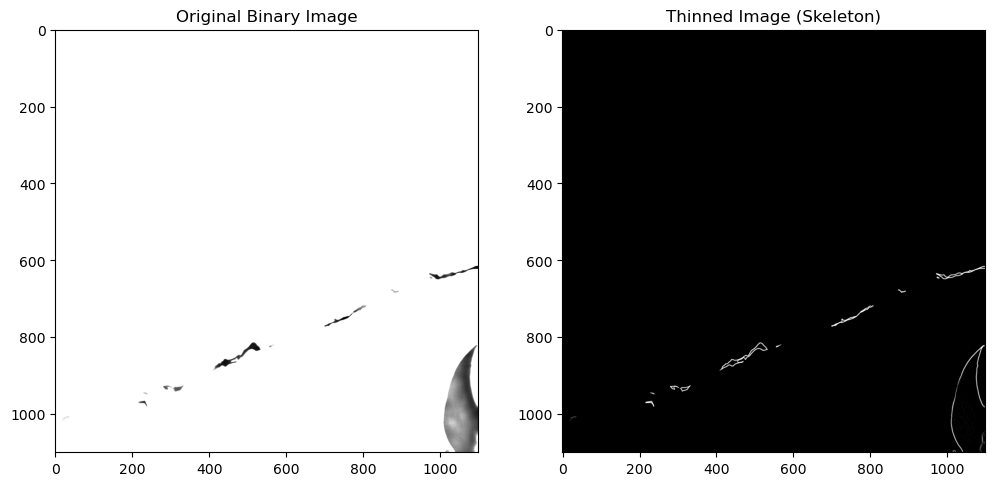

In [36]:
#convert forgeground to background and vice-versa
image = np.array(image_homomorphic_filter)

thr = np.percentile(image[(image > 0)], 1)*0.9
image[(image <= thr)] = thr
image = image - np.min(image)
image = image / np.max(image)
#sigma=[0.5,1, 1.5, 2, 2.5]
sigma=[1]
spacing = [1, 1]
tau = 1

output = vesselness2d(image, sigma, spacing, tau)
vessleness_img = output.vesselness2d()

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Original Binary Image")
plt.imshow(image_homomorphic_filter, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Thinned Image (Skeleton)")
plt.imshow(vessleness_img, cmap='gray')
plt.show()

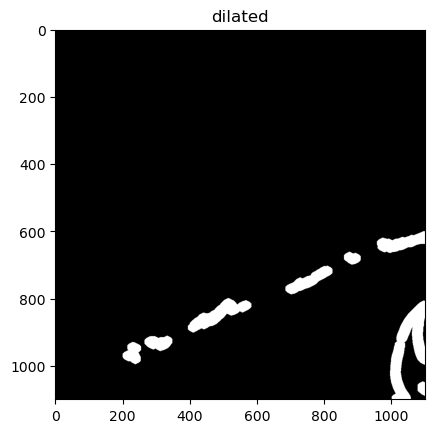

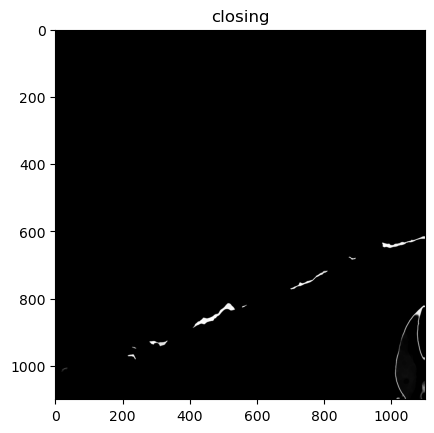

In [37]:
# 闭运算
# 二值化处理，根据需要调整阈值
_, binary_image = cv2.threshold(vessleness_img * 255, 127, 255, cv2.THRESH_BINARY)

# 定义结构元素，这里使用一个3x3的矩形结构元素
# 创建一个5x5的矩形结构元素
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

# 创建一个5x5的椭圆形结构元素
ellipse_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))

# 创建一个5x5的十字形结构元素
cross_kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (7, 7))


# 执行膨胀操作
dilated_image = cv2.dilate(binary_image, ellipse_kernel, iterations=5)

plt.title("dilated")
plt.imshow(dilated_image, cmap='gray')
plt.show()


# 定义结构元素，这里使用一个5x5的矩形结构元素

# 创建一个5x5的矩形结构元素
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
# 创建一个5x5的椭圆形结构元素
ellipse_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
# 创建一个5x5的十字形结构元素
cross_kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (15, 15))

kernel = np.ones((5, 5), np.uint8)

# 进行闭运算
closing = cv2.morphologyEx(vessleness_img * 255, cv2.MORPH_CLOSE, ellipse_kernel)
plt.title("closing")
plt.imshow(closing, cmap='gray')
plt.show()

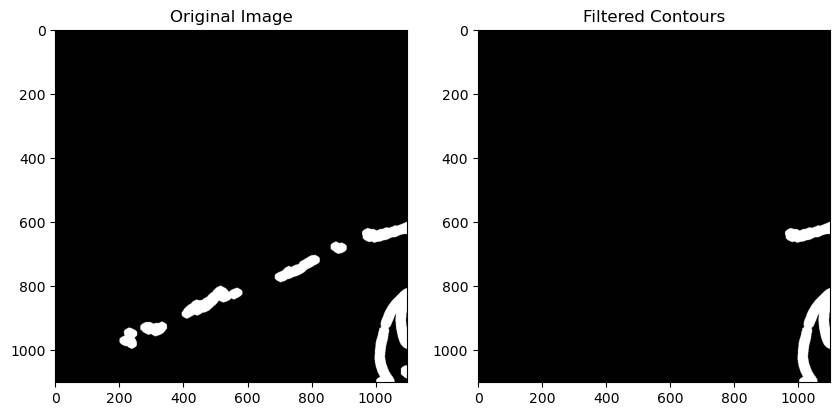

In [38]:
# 应用二值化处理
_, binary = cv2.threshold(dilated_image.astype(np.uint8), 127, 255, cv2.THRESH_BINARY)
# 检测轮廓
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 计算自适应面积阈值（例如取轮廓面积的平均值）
areas = [cv2.contourArea(cnt) for cnt in contours]
mean_area = np.mean(areas)

# 设定阈值比例（可以根据需求调整）
area_threshold = 1 * mean_area

# 创建一个空白图像用于绘制符合面积阈值的轮廓

output = np.zeros(image.shape[:2], dtype='uint8')  # 仅取宽高两维

# 计算轮廓的外接矩形长宽比
def aspect_ratio(contour):
    x, y, w, h = cv2.boundingRect(contour)
    return float(w) / h if h > 0 else 0


# 筛选并绘制符合条件的轮廓
for cnt in contours:
    area = cv2.contourArea(cnt)
    ratio = aspect_ratio(cnt)
    if area >= area_threshold and ratio>2 or ratio<0.5:  # 保留面积大于阈值的轮廓
        cv2.drawContours(output, [cnt], -1, (255), thickness=cv2.FILLED)

areathreshold_img = output
# 显示结果
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(dilated_image, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Filtered Contours")
plt.imshow(areathreshold_img, cmap='gray')


In [39]:
'''vesselness_img_scaled = (vessleness_img*255).astype(np.uint8)

ret, thresh = cv2.threshold(vesselness_img_scaled, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print(ret)  # 124
# adaptive threshold
thresh1 = cv2.adaptiveThreshold(vesselness_img_scaled, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 0)
thresh2 = cv2.adaptiveThreshold(vesselness_img_scaled, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
thresh3 = cv2.adaptiveThreshold(vesselness_img_scaled, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 0)
thresh4 = cv2.adaptiveThreshold(vesselness_img_scaled, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
 
# show image
plt.figure('adaptive threshold', figsize=(12, 8))
plt.subplot(231), plt.imshow(vesselness_img_scaled, cmap='gray'), plt.title('original')
plt.subplot(234), plt.imshow(thresh, cmap='gray'), plt.title('otsu')
plt.subplot(232), plt.imshow(thresh1, cmap='gray'), plt.title('adaptive_mean_0')
plt.subplot(235), plt.imshow(thresh2, cmap='gray'), plt.title('adaptive_mean_2')
plt.subplot(233), plt.imshow(thresh3, cmap='gray'), plt.title('adaptive_gaussian_0')
plt.subplot(236), plt.imshow(thresh4, cmap='gray'), plt.title('adaptive_gaussian_2')
plt.show()
plt.imshow(thresh, cmap='gray'), plt.title('otsu')'''


"vesselness_img_scaled = (vessleness_img*255).astype(np.uint8)\n\nret, thresh = cv2.threshold(vesselness_img_scaled, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)\nprint(ret)  # 124\n# adaptive threshold\nthresh1 = cv2.adaptiveThreshold(vesselness_img_scaled, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 0)\nthresh2 = cv2.adaptiveThreshold(vesselness_img_scaled, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)\nthresh3 = cv2.adaptiveThreshold(vesselness_img_scaled, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 0)\nthresh4 = cv2.adaptiveThreshold(vesselness_img_scaled, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)\n \n# show image\nplt.figure('adaptive threshold', figsize=(12, 8))\nplt.subplot(231), plt.imshow(vesselness_img_scaled, cmap='gray'), plt.title('original')\nplt.subplot(234), plt.imshow(thresh, cmap='gray'), plt.title('otsu')\nplt.subplot(232), plt.imshow(thresh1, cmap='gray'), plt.title('adaptive_mean_0')\nplt.subplot(235), plt

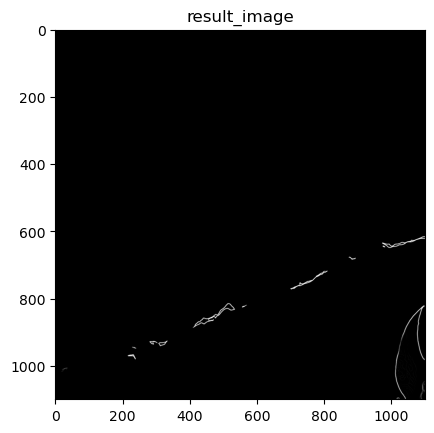

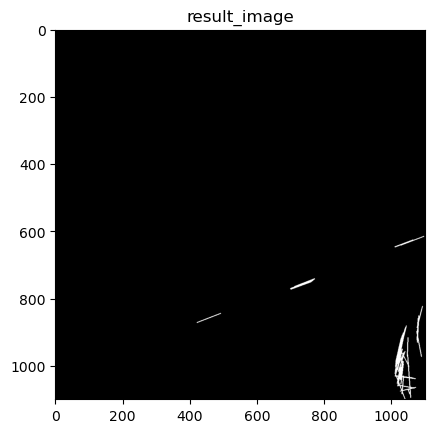

In [40]:
import math

# 计算两条线段之间的夹角（角度制）
def angle_between_segments(segment1, segment2):
    x1, y1, x2, y2 = segment1
    x3, y3, x4, y4 = segment2
    v1 = (x2 - x1, y2 - y1)
    v2 = (x4 - x3, y4 - y3)
    dot_product = v1[0] * v2[0] + v1[1] * v2[1]
    magnitude1 = math.sqrt(v1[0] ** 2 + v1[1] ** 2)
    magnitude2 = math.sqrt(v2[0] ** 2 + v2[1] ** 2)
    cos_angle = dot_product / (magnitude1 * magnitude2)
    return math.degrees(math.acos(cos_angle))


# 计算两点之间的距离
def distance(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)


# 线段连接函数
def link_segments(segments, distance_threshold=10, angle_threshold=30):
    """
    segments: 线段列表，每个线段用起点和终点坐标表示，例如[(x1,y1,x2,y2), (x3,y3,x4,y4),...]
    distance_threshold: 距离阈值，小于此距离的端点认为可连接
    angle_threshold: 角度阈值，小于此角度的线段认为方向相近可连接
    """
    linked_segments = []
    num_segments = len(segments)
    processed = [False] * num_segments
    for i in range(num_segments):
        if processed[i]:
            continue
        current_segment = segments[i]
        merged_segment = list(current_segment)
        for j in range(i + 1, num_segments):
            if processed[j]:
                continue
            other_segment = segments[j]
            # 检查端点距离
            dist1 = distance((current_segment[2], current_segment[3]), (other_segment[0], other_segment[1]))
            dist2 = distance((current_segment[0], current_segment[1]), (other_segment[2], other_segment[3]))
            if dist1 < distance_threshold or dist2 < distance_threshold:
                # 检查角度
                angle1 = angle_between_segments(current_segment, other_segment)
                angle2 = angle_between_segments((current_segment[2], current_segment[3], current_segment[0], current_segment[1]),
                                               other_segment)
                if angle1 < angle_threshold or angle2 < angle_threshold:
                    # 合并线段
                    if dist1 < distance_threshold:
                        merged_segment[2] = other_segment[2]
                        merged_segment[3] = other_segment[3]
                    else:
                        merged_segment[0] = other_segment[0]
                        merged_segment[1] = other_segment[1]
                    processed[j] = True
        linked_segments.append(tuple(merged_segment))
    return linked_segments


# 读取二值化图像（这里假设你已经有了二值化图像，你可以根据实际情况替换下面的文件名）
binary_image = (vessleness_img* 255).astype(np.uint8)

# 使用霍夫变换提取线段
lines = cv2.HoughLinesP(binary_image, 1, np.pi / 180, 50, minLineLength=50, maxLineGap=10)
extracted_segments = []
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        extracted_segments.append((x1, y1, x2, y2))

# 对提取的线段进行连接
linked_segments = link_segments(extracted_segments)

# 可以将连接后的线段绘制回图像查看效果（创建一个空白图像用于绘制）
result_image = np.zeros_like(binary_image)
for segment in linked_segments:
    x1, y1, x2, y2 = segment
    cv2.line(result_image, (x1, y1), (x2, y2), 255, 2)


plt.title("result_image")
plt.imshow(binary_image, cmap='gray')
plt.show()
plt.title("result_image")
plt.imshow(result_image, cmap='gray')
plt.show()



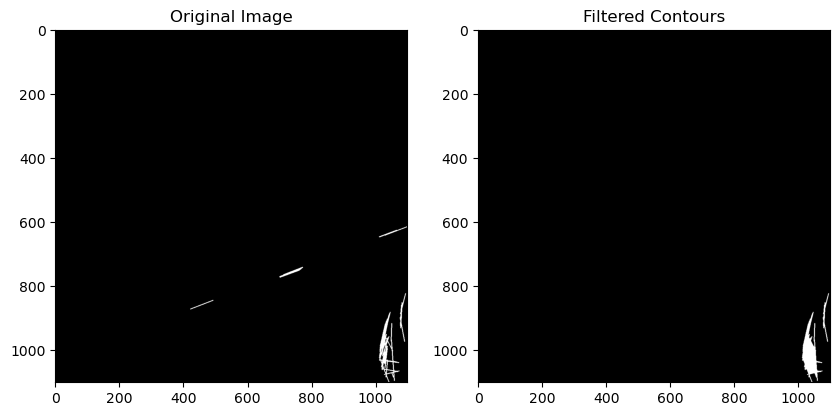

In [41]:
# 应用二值化处理
_, binary = cv2.threshold(result_image.astype(np.uint8), 127, 255, cv2.THRESH_BINARY)
# 检测轮廓
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 计算自适应面积阈值（例如取轮廓面积的平均值）
areas = [cv2.contourArea(cnt) for cnt in contours]
mean_area = np.mean(areas)

# 设定阈值比例（可以根据需求调整）
area_threshold = 1 * mean_area

# 创建一个空白图像用于绘制符合面积阈值的轮廓

output = np.zeros(image.shape[:2], dtype='uint8')  # 仅取宽高两维

# 计算轮廓的外接矩形长宽比
def aspect_ratio(contour):
    x, y, w, h = cv2.boundingRect(contour)
    return float(w) / h if h > 0 else 0


# 筛选并绘制符合条件的轮廓
for cnt in contours:
    area = cv2.contourArea(cnt)
    ratio = aspect_ratio(cnt)
    if area >= area_threshold and ratio>2 or ratio<0.5:  # 保留面积大于阈值的轮廓
        cv2.drawContours(output, [cnt], -1, (255), thickness=cv2.FILLED)

areathreshold_img = output
# 显示结果
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(result_image, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Filtered Contours")
plt.imshow(areathreshold_img, cmap='gray')


In [42]:
def zhang_suen_thinning1(image):
    # 确保图像为二值化图像
    binary_image = (image > 0).astype(np.uint8)

    '''def neighbours(x, y):
        """返回给定像素的 8 个邻居像素的值"""
        return [binary_image[x-1, y], binary_image[x-1, y+1], binary_image[x, y+1], binary_image[x+1, y+1],
                binary_image[x+1, y], binary_image[x+1, y-1], binary_image[x, y-1], binary_image[x-1, y-1]]'''
    def neighbours(x, y):
        """返回给定像素的8个邻居像素的值"""
        # 确保坐标在图像范围内（边界处理）
        x = max(0, min(x, binary_image.shape[0] - 1))
        y = max(0, min(y, binary_image.shape[1] - 1))
        # 获取邻居像素值，考虑边界情况，超出边界的设为0（可根据实际需求调整边界处理方式）
        top = binary_image[max(0, x - 1), y] if x > 0 else 0
        top_right = binary_image[max(0, x - 1), min(y + 1, binary_image.shape[1] - 1)] if x > 0 else 0
        right = binary_image[x, min(y + 1, binary_image.shape[1] - 1)] if y < binary_image.shape[1] - 1 else 0
        bottom_right = binary_image[min(x + 1, binary_image.shape[0] - 1), min(y + 1, binary_image.shape[1] - 1)] if x < binary_image.shape[0] - 1 else 0
        bottom = binary_image[min(x + 1, binary_image.shape[0] - 1), y] if x < binary_image.shape[0] - 1 else 0
        bottom_left = binary_image[min(x + 1, binary_image.shape[0] - 1), max(0, y - 1)] if x < binary_image.shape[0] - 1 else 0
        left = binary_image[x, max(0, y - 1)] if y > 0 else 0
        top_left = binary_image[max(0, x - 1), max(0, y - 1)] if x > 0 else 0
        return [top, top_right, right, bottom_right, bottom, bottom_left, left, top_left]
        
    def transitions(neighbours):
        """计算从 0 到 1 的转换次数"""
        n = neighbours + neighbours[0:1]  # 环绕一下
        return sum((n1 == 0 and n2 == 1) for n1, n2 in zip(n[:-1], n[1:]))

    def step1():
        """第一步移除点集"""
        to_remove = []
        # 创建数组来记录像素点是否可能需要重新计算（初始化为True，表示都需要先重新计算）
        need_recalculate = np.ones(binary_image.shape, dtype=bool)
        while True:
            updated_need_recalculate = np.ones(binary_image.shape, dtype=bool)
            for i in range(1, binary_image.shape[0] - 1):
                for j in range(1, binary_image.shape[1] - 1):
                    if not need_recalculate[i, j]:
                        continue
                    P = neighbours(i, j)
                    if (binary_image[i, j] == 1 and
                        2 <= sum(P) <= 6 and
                        transitions(P) == 1 and
                        P[0] * P[2] * P[4] == 0 and
                        P[2] * P[4] * P[6] == 0):
                        to_remove.append((i, j))
                        updated_need_recalculate[i, j] = False
                        updated_need_recalculate[max(0, i - 1):min(i + 2, binary_image.shape[0]),
                                                max(0, j - 1):min(j + 2, binary_image.shape[1])] = True
            if not np.any(updated_need_recalculate):
                break
            need_recalculate = updated_need_recalculate
        for i, j in to_remove:
            binary_image[i, j] = 0

    def step2():
        """第二步移除点集"""
        to_remove = []
        for i in range(1, binary_image.shape[0] - 1):
            for j in range(1, binary_image.shape[1] - 1):
                P = neighbours(i, j)
                if (binary_image[i, j] == 1 and
                    2 <= sum(P) <= 6 and
                    transitions(P) == 1 and
                    P[0] * P[2] * P[6] == 0 and
                    P[0] * P[4] * P[6] == 0):
                    to_remove.append((i, j))
        for i, j in to_remove:
            binary_image[i, j] = 0

    # 执行迭代细化步骤，直到没有像素再被移除
    prev_image = np.zeros(binary_image.shape, np.uint8)
    while True:
        step1()
        step2()
        if np.array_equal(prev_image, binary_image):
            break
        prev_image = binary_image.copy()

    return binary_image


In [43]:
#thinning_img = zhang_suen_thinning(vessleness_img)
thinning_img1 = zhang_suen_thinning1(areathreshold_img)


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Binary Image")
plt.imshow(areathreshold_img, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Thinned Image (Skeleton)")
plt.imshow(thinning_img1, cmap='gray')
plt.show()

KeyboardInterrupt: 

Text(0.5, 1.0, 'Original Image')

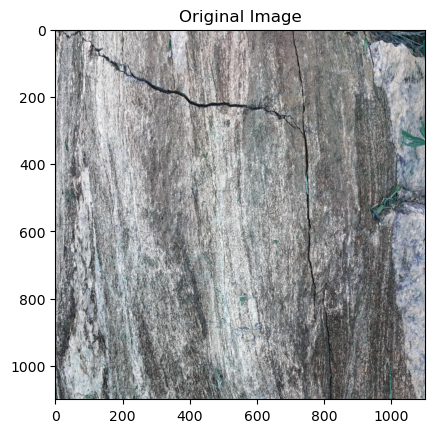

In [ ]:
plt.imshow(image_color, cmap='gray')
plt.title('Original Image')